In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

# Add project root to path (avoids jax import issues from testing/)
parent_dir = Path.cwd().resolve()
if parent_dir.name == 'testing':
    parent_dir = parent_dir.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
os.chdir(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jax
import jax.numpy as jnp
import jax.random as random
import time

import jax_gibbs as gs_jax
import utils

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Configuration
T_gibbs = 50000
T_kde = 50000

# Test parameters
ks = [1.0, 2.0, 3.0, 5.0]
ms = [10, 20, 50, 100]     # Different m values
mu_true = 2.0

# Common sampler parameters
base_params = {
    'mu_true': mu_true,
    'prior_mean': 0.0,
    'prior_std': 10.0,
    'proposal_std_mu': 0.9,
    'proposal_std_z': 0.03,
}

print(f"Configuration:")
print(f"  Gibbs chain length: T = {T_gibbs:,}")
print(f"  KDE simulations: {T_kde:,}")
print(f"  Testing k values: {ks}")
print(f"  Testing m values: {ms}")
print(f"  True μ = {mu_true}")


Configuration:
  Gibbs chain length: T = 50,000
  KDE simulations: 50,000
  Testing k values: [1.0, 2.0, 3.0, 5.0]
  Testing m values: [10, 20, 50, 100]
  True μ = 2.0


## Part 1: Focus on k=1 (Cauchy)


In [3]:
# Focus on k=1 (Cauchy case)
k_cauchy = 1.0
m_test = 100

# Set up parameters
params = base_params.copy()
params['k'] = k_cauchy
params['m'] = m_test
params['num_iterations_T'] = T_gibbs

# Generate data
key = random.PRNGKey(42)
key, subkey = random.split(key)
data = random.t(subkey, df=k_cauchy, shape=(m_test,)) + mu_true
mle = utils.get_mle(data, params)

print(f"k = {k_cauchy} (Cauchy), m = {m_test}")
print(f"Generated data: {data}")
print(f"Calculated MLE μ* = {mle:.4f}")
print(f"True μ = {mu_true:.4f}")


k = 1.0 (Cauchy), m = 100
Generated data: [-2.25919339e+00 -2.84229171e-02  2.30742177e+00  3.59600687e-01
  1.92624690e+00 -1.05531304e+01  5.60238592e+00  2.96940796e-01
 -2.59354836e+00  2.42935263e+00  9.29453975e-01  3.32984763e+00
  1.27689337e+00  8.55287487e+00  1.94661019e-03  4.48162878e-01
  1.76162236e+00  4.39604217e+00  2.01117711e+00  4.27076075e+00
  2.71600772e+00  2.14838349e+00  3.01937975e+00  2.55658290e+00
  8.32554551e+00  3.81411892e+00  8.11370782e-01 -1.71359191e+00
  2.32816188e+00  1.31207002e+00  1.12543423e+00  2.73006442e+00
  4.87648864e+00 -9.28388088e-01  3.38096899e+00 -5.48209958e+00
  2.33731133e-02  3.21222429e+00  2.06758450e+00  1.52274643e+00
  3.11779955e+00  2.05454720e+00  2.51569852e+00  1.79465105e+00
  2.12825947e+00  1.37056623e+00  8.72910858e-01  2.44419114e+00
  2.81352823e+00 -5.15275951e-01  3.39214627e+00 -3.41642795e+00
 -6.80544000e-01 -1.04251388e+00  6.28083113e-01  8.23347306e+00
 -1.53536863e+00  7.52882421e+00  3.74019335e+00

In [4]:
# Run JAX Gibbs sampler
print("Running JAX Gibbs sampler...")
t0 = time.time()
key_gibbs = random.PRNGKey(123)
gibbs_results = gs_jax.run_gibbs_sampler_mle_jax(key_gibbs, mle, params)
time_gibbs = time.time() - t0

mu_chain_gibbs = np.array(gibbs_results['mu_chain'])
print(f"\nGibbs sampler completed in {time_gibbs:.2f} seconds")
print(f"Mu acceptance rate: {gibbs_results['mu_acceptance_rate']:.4f}")
print(f"Z_i acceptance rate: {gibbs_results['z_i_acceptance_rate']:.4f}")


Running JAX Gibbs sampler...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:32<00:00, 543.21it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.2009
Z_i Acceptance Rate: 0.7782

Gibbs sampler completed in 92.15 seconds
Mu acceptance rate: 0.2009
Z_i acceptance rate: 0.7782


In [5]:
# Compute KDE-based posterior
print("Computing KDE-based posterior...")
t0 = time.time()
params['kde_bw_method'] = .001
kde_posterior_pdf = utils.get_normalized_posterior_mle_pdf(mle, params, num_simulations=T_kde)
time_kde = time.time() - t0

print(f"KDE computation completed in {time_kde:.2f} seconds")


Computing KDE-based posterior...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001
KDE computation completed in 8.38 seconds


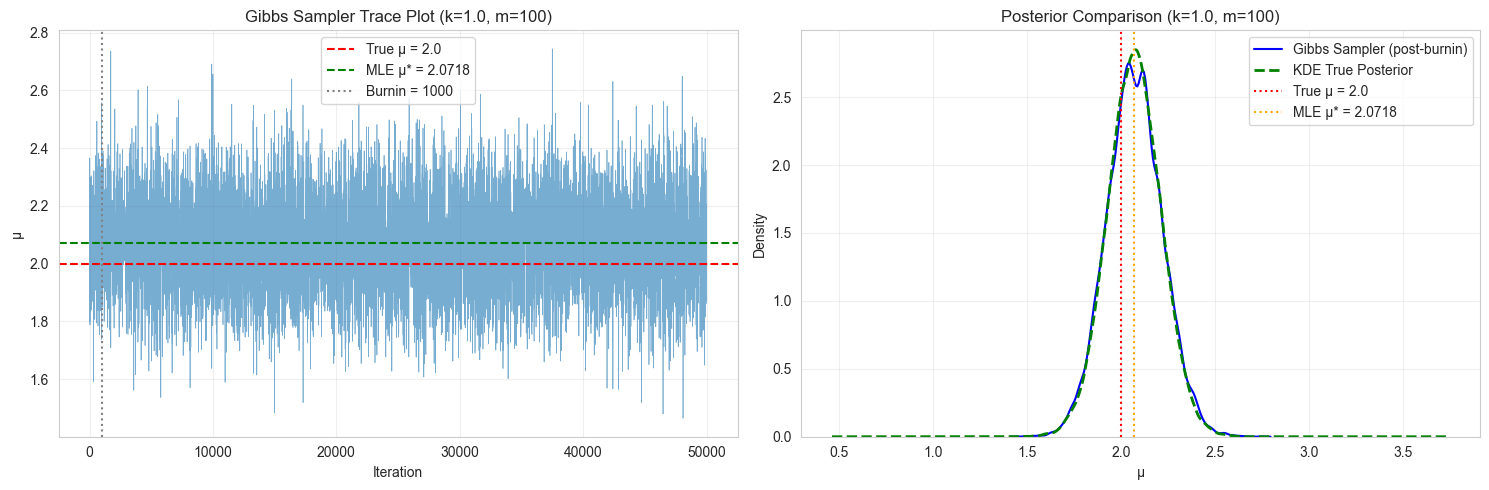


Gibbs Sampler Statistics (post-burnin):
  Mean: 2.0719
  Std:  0.1474
  Variance: 0.0217


In [6]:
# Compare Gibbs sampler with KDE
burnin = 1000
mu_chain_post_burnin = mu_chain_gibbs[burnin:]

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Trace plot
axes[0].plot(mu_chain_gibbs, alpha=0.6, linewidth=0.5)
axes[0].axhline(mu_true, color='red', linestyle='--', label=f'True μ = {mu_true}')
axes[0].axhline(mle, color='green', linestyle='--', label=f'MLE μ* = {mle:.4f}')
axes[0].axvline(burnin, color='gray', linestyle=':', label=f'Burnin = {burnin}')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('μ')
axes[0].set_title(f'Gibbs Sampler Trace Plot (k={k_cauchy}, m={m_test})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Density comparison
mu_grid = np.linspace(mu_chain_post_burnin.min() - 1, mu_chain_post_burnin.max() + 1, 1000)
kde_pdf_values = kde_posterior_pdf(mu_grid)

sns.kdeplot(mu_chain_post_burnin, label='Gibbs Sampler (post-burnin)', ax=axes[1], color='blue')
axes[1].plot(mu_grid, kde_pdf_values, label='KDE True Posterior', color='green', linestyle='--', linewidth=2)
axes[1].axvline(mu_true, color='red', linestyle=':', label=f'True μ = {mu_true}')
axes[1].axvline(mle, color='orange', linestyle=':', label=f'MLE μ* = {mle:.4f}')
axes[1].set_xlabel('μ')
axes[1].set_ylabel('Density')
axes[1].set_title(f'Posterior Comparison (k={k_cauchy}, m={m_test})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'gibbs_vs_kde_k{int(k_cauchy)}_m{m_test}.pdf', dpi=300)
plt.show()

# Print statistics
print(f"\nGibbs Sampler Statistics (post-burnin):")
print(f"  Mean: {mu_chain_post_burnin.mean():.4f}")
print(f"  Std:  {mu_chain_post_burnin.std():.4f}")
print(f"  Variance: {mu_chain_post_burnin.var():.4f}")


## Part 2: Empirical Variance Analysis for Different k and m

The empirical variance of the posterior given the MLE for different k and m values.


In [12]:
# Store results for variance analysis
results = {
    'k': [],
    'm': [],
    'gibbs_variance': [],
    'kde_variance': [],
    'gibbs_mean': [],
    'kde_mean': [],
    'mle': [],
    'time_gibbs': [],
    'time_kde': []
}

# Run analysis for different k and m combinations
key = random.PRNGKey(0)
for k in ks:
    for m in ms:
        print(f"\n{'='*60}")
        print(f"Processing k={k}, m={m}")
        print(f"{'='*60}")
        
        # Set up parameters
        params = base_params.copy()
        params['k'] = k
        params['m'] = m
        params['num_iterations_T'] = T_gibbs
        
        # Generate data
        key, subkey = random.split(key)
        data = random.t(subkey, df=k, shape=(m,)) + mu_true
        mle = utils.get_mle(data, params)
        
        # Run Gibbs sampler
        print(f"  Running Gibbs sampler (T={T_gibbs:,})...")
        key, key_gibbs = random.split(key)
        t0 = time.time()
        gibbs_results = gs_jax.run_gibbs_sampler_mle_jax(key_gibbs, mle, params)
        time_gibbs = time.time() - t0
        
        mu_chain_gibbs = np.array(gibbs_results['mu_chain'])
        burnin = 1000
        mu_chain_post_burnin = mu_chain_gibbs[burnin:]
        
        # Compute KDE posterior (k=1 uses bw_method=0.001)
        if k == 1.0:
            params['kde_bw_method'] = 0.001
        print(f"  Computing KDE posterior ({T_kde:,} simulations)...")
        t0 = time.time()
        kde_posterior_pdf = utils.get_normalized_posterior_mle_pdf(mle, params, num_simulations=T_kde)
        time_kde = time.time() - t0
        
        # Compute variance using numerical integration for KDE
        mu_grid = np.linspace(mu_chain_post_burnin.min() - 2, mu_chain_post_burnin.max() + 2, 2000)
        kde_pdf_values = kde_posterior_pdf(mu_grid)
        
        # Normalize KDE pdf (in case of numerical issues)
        kde_pdf_values = kde_pdf_values / np.trapezoid(kde_pdf_values, mu_grid)
        
        # Compute KDE mean and variance
        kde_mean = np.trapezoid(mu_grid * kde_pdf_values, mu_grid)
        kde_variance = np.trapezoid((mu_grid - kde_mean)**2 * kde_pdf_values, mu_grid)
        
        # Store results
        results['k'].append(k)
        results['m'].append(m)
        results['gibbs_variance'].append(mu_chain_post_burnin.var())
        results['kde_variance'].append(kde_variance)
        results['gibbs_mean'].append(mu_chain_post_burnin.mean())
        results['kde_mean'].append(kde_mean)
        results['mle'].append(mle)
        results['time_gibbs'].append(time_gibbs)
        results['time_kde'].append(time_kde)
        
        print(f"  Gibbs variance: {mu_chain_post_burnin.var():.6f}")
        print(f"  KDE variance:   {kde_variance:.6f}")
        print(f"  Variance ratio (Gibbs/KDE): {mu_chain_post_burnin.var()/kde_variance:.4f}")
        print(f"  Time - Gibbs: {time_gibbs:.2f}s, KDE: {time_kde:.2f}s")



Processing k=1.0, m=10
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:43<00:00, 1150.12it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5414
Z_i Acceptance Rate: 0.4866
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001


/Users/shlokmishra/code/student_t_mle/utils.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda mu: np.exp(log_unnorm(mu)), -np.inf, np.inf)


  Gibbs variance: 87.382937
  KDE variance:   0.520747
  Variance ratio (Gibbs/KDE): 167.8029
  Time - Gibbs: 43.51s, KDE: 11.86s

Processing k=1.0, m=20
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:49<00:00, 1019.85it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4223
Z_i Acceptance Rate: 0.7735
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001


/Users/shlokmishra/code/student_t_mle/utils.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda mu: np.exp(log_unnorm(mu)), -np.inf, np.inf)


  Gibbs variance: 0.147802
  KDE variance:   0.117826
  Variance ratio (Gibbs/KDE): 1.2544
  Time - Gibbs: 49.06s, KDE: 9.53s

Processing k=1.0, m=50
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:06<00:00, 754.62it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2799
Z_i Acceptance Rate: 0.7783
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001


/Users/shlokmishra/code/student_t_mle/utils.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda mu: np.exp(log_unnorm(mu)), -np.inf, np.inf)


  Gibbs variance: 0.044608
  KDE variance:   0.042864
  Variance ratio (Gibbs/KDE): 1.0407
  Time - Gibbs: 66.30s, KDE: 11.29s

Processing k=1.0, m=100
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:30<00:00, 552.28it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2009
Z_i Acceptance Rate: 0.7802
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001
  Gibbs variance: 0.021308
  KDE variance:   0.020851
  Variance ratio (Gibbs/KDE): 1.0219
  Time - Gibbs: 90.55s, KDE: 7.97s

Processing k=2.0, m=10
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:41<00:00, 1214.81it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4958
Z_i Acceptance Rate: 0.7109
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.226478
  KDE variance:   0.191351
  Variance ratio (Gibbs/KDE): 1.1836
  Time - Gibbs: 41.16s, KDE: 6.19s

Processing k=2.0, m=20
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:56<00:00, 884.48it/s] 



--- Sampling Complete ---
Mu Acceptance Rate: 0.3781
Z_i Acceptance Rate: 0.7201
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.095813
  KDE variance:   0.090282
  Variance ratio (Gibbs/KDE): 1.0613
  Time - Gibbs: 56.53s, KDE: 5.93s

Processing k=2.0, m=50
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:18<00:00, 633.06it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2492
Z_i Acceptance Rate: 0.7260
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.033806
  KDE variance:   0.034516
  Variance ratio (Gibbs/KDE): 0.9794
  Time - Gibbs: 78.99s, KDE: 6.90s

Processing k=2.0, m=100
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:40<00:00, 496.12it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.1789
Z_i Acceptance Rate: 0.7245
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.017365
  KDE variance:   0.017224
  Variance ratio (Gibbs/KDE): 1.0082
  Time - Gibbs: 100.79s, KDE: 6.95s

Processing k=3.0, m=10
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:00<00:00, 830.50it/s] 



--- Sampling Complete ---
Mu Acceptance Rate: 0.4680
Z_i Acceptance Rate: 0.7206
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.180557
  KDE variance:   0.164158
  Variance ratio (Gibbs/KDE): 1.0999
  Time - Gibbs: 60.21s, KDE: 6.59s

Processing k=3.0, m=20
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:58<00:00, 850.86it/s] 



--- Sampling Complete ---
Mu Acceptance Rate: 0.3601
Z_i Acceptance Rate: 0.7286
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.081361
  KDE variance:   0.078635
  Variance ratio (Gibbs/KDE): 1.0347
  Time - Gibbs: 58.77s, KDE: 6.25s

Processing k=3.0, m=50
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:14<00:00, 669.56it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2379
Z_i Acceptance Rate: 0.7317
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.031372
  KDE variance:   0.030803
  Variance ratio (Gibbs/KDE): 1.0185
  Time - Gibbs: 74.68s, KDE: 7.01s

Processing k=3.0, m=100
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:34<00:00, 530.49it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.1688
Z_i Acceptance Rate: 0.7321
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.015245
  KDE variance:   0.015311
  Variance ratio (Gibbs/KDE): 0.9957
  Time - Gibbs: 94.26s, KDE: 5.93s

Processing k=5.0, m=10
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:40<00:00, 1249.46it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4414
Z_i Acceptance Rate: 0.8022
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.143954
  KDE variance:   0.139543
  Variance ratio (Gibbs/KDE): 1.0316
  Time - Gibbs: 40.02s, KDE: 5.24s

Processing k=5.0, m=20
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:44<00:00, 1113.44it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.3312
Z_i Acceptance Rate: 0.7994
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.069412
  KDE variance:   0.069232
  Variance ratio (Gibbs/KDE): 1.0026
  Time - Gibbs: 44.91s, KDE: 5.61s

Processing k=5.0, m=50
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:01<00:00, 813.72it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2201
Z_i Acceptance Rate: 0.8036
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.026188
  KDE variance:   0.027148
  Variance ratio (Gibbs/KDE): 0.9647
  Time - Gibbs: 61.45s, KDE: 5.21s

Processing k=5.0, m=100
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:34<00:00, 530.93it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.1567
Z_i Acceptance Rate: 0.8046
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.013072
  KDE variance:   0.013724
  Variance ratio (Gibbs/KDE): 0.9524
  Time - Gibbs: 94.18s, KDE: 6.04s


In [13]:
# Create summary table
import pandas as pd

df_results = pd.DataFrame(results)
print("\n" + "="*80)
print("SUMMARY: Empirical Variance Analysis")
print("="*80)
print(df_results.to_string(index=False))



SUMMARY: Empirical Variance Analysis
  k   m  gibbs_variance  kde_variance  gibbs_mean  kde_mean      mle  time_gibbs  time_kde
1.0  10       87.382937      0.520747   -7.639908  2.053095 2.063652   43.510515 11.862687
1.0  20        0.147802      0.117826    1.938346  1.946689 1.946915   49.062098  9.525605
1.0  50        0.044608      0.042864    1.583177  1.585122 1.586572   66.298555 11.285340
1.0 100        0.021308      0.020851    2.011031  2.009877 2.010608   90.545627  7.967181
2.0  10        0.226478      0.191351    1.842952  1.852149 1.857898   41.161966  6.187164
2.0  20        0.095813      0.090282    1.611321  1.612954 1.613111   56.533213  5.930794
2.0  50        0.033806      0.034516    1.719612  1.721881 1.721247   78.987977  6.897583
2.0 100        0.017365      0.017224    2.011298  2.011596 2.011085  100.789534  6.954200
3.0  10        0.180557      0.164158    1.570055  1.564849 1.570248   60.207335  6.594481
3.0  20        0.081361      0.078635    1.693084  1

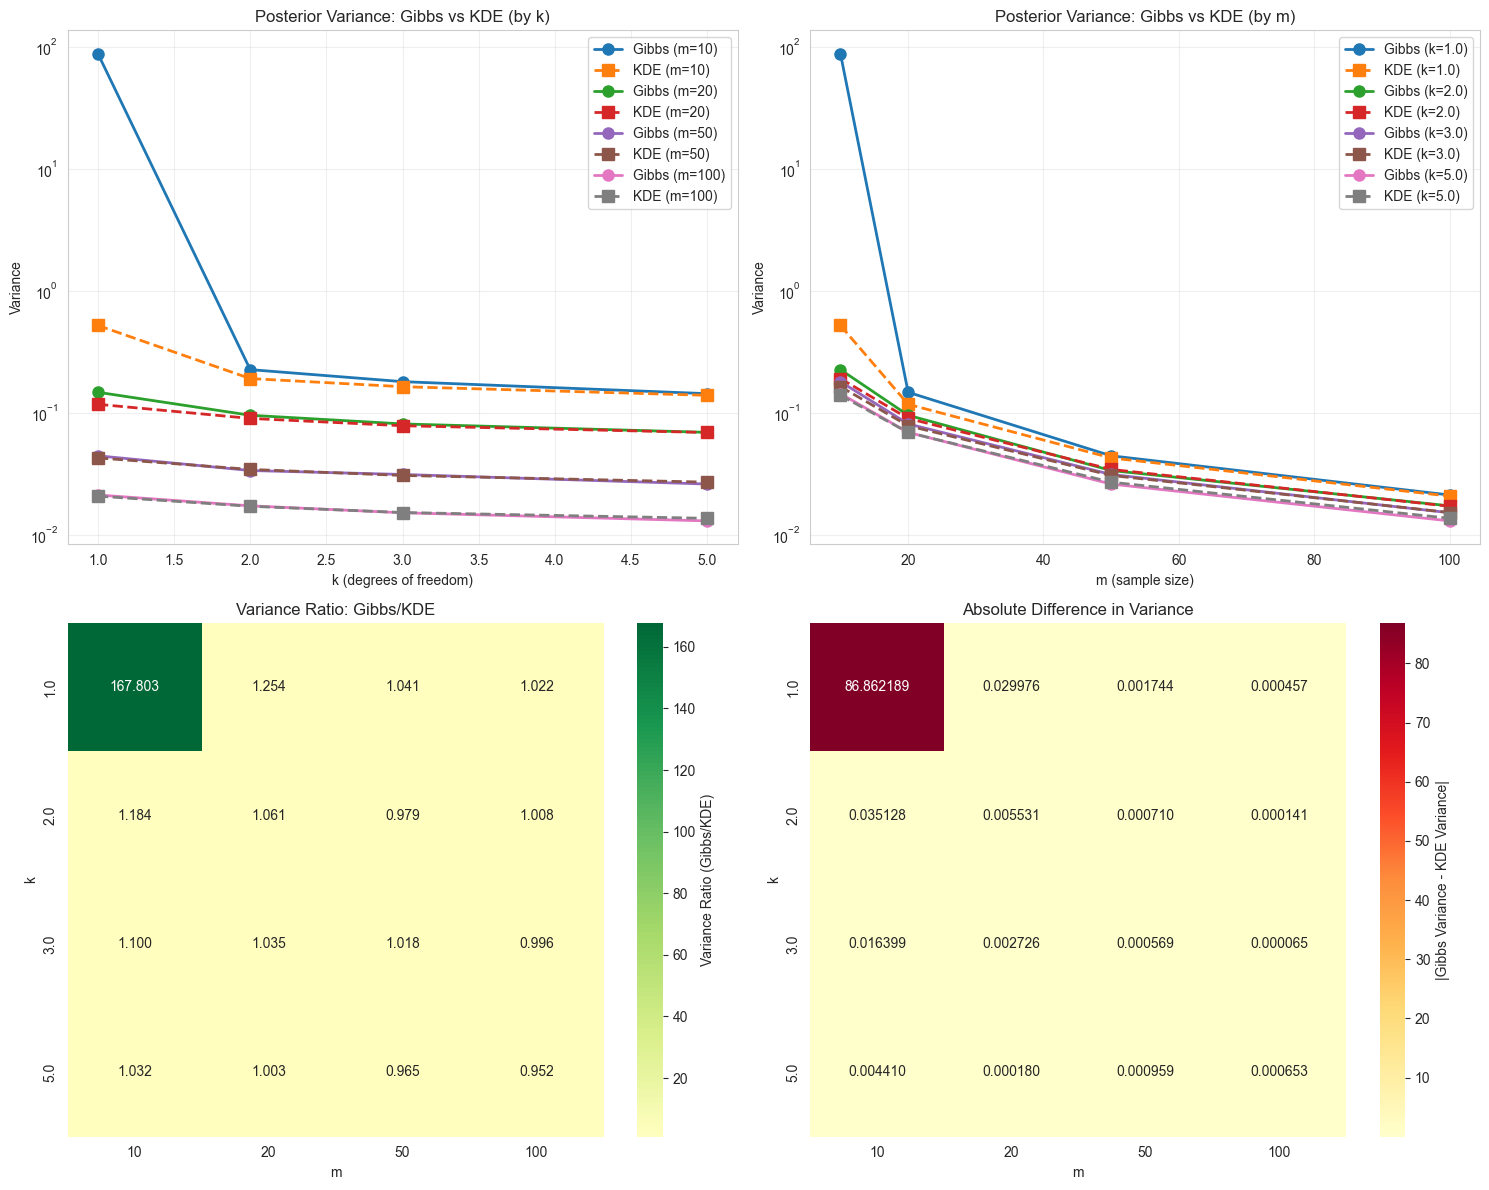

In [14]:
# Visualize variance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Variance comparison by k
for m in ms:
    mask = df_results['m'] == m
    axes[0, 0].plot(df_results[mask]['k'], df_results[mask]['gibbs_variance'], 
                    'o-', label=f'Gibbs (m={m})', linewidth=2, markersize=8)
    axes[0, 0].plot(df_results[mask]['k'], df_results[mask]['kde_variance'], 
                    's--', label=f'KDE (m={m})', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('k (degrees of freedom)')
axes[0, 0].set_ylabel('Variance')
axes[0, 0].set_title('Posterior Variance: Gibbs vs KDE (by k)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Variance comparison by m
for k in ks:
    mask = df_results['k'] == k
    axes[0, 1].plot(df_results[mask]['m'], df_results[mask]['gibbs_variance'], 
                    'o-', label=f'Gibbs (k={k})', linewidth=2, markersize=8)
    axes[0, 1].plot(df_results[mask]['m'], df_results[mask]['kde_variance'], 
                    's--', label=f'KDE (k={k})', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('m (sample size)')
axes[0, 1].set_ylabel('Variance')
axes[0, 1].set_title('Posterior Variance: Gibbs vs KDE (by m)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Variance ratio (Gibbs/KDE)
df_results['variance_ratio'] = df_results['gibbs_variance'] / df_results['kde_variance']
pivot_ratio = df_results.pivot(index='k', columns='m', values='variance_ratio')
sns.heatmap(pivot_ratio, annot=True, fmt='.3f', cmap='RdYlGn', center=1.0, 
            ax=axes[1, 0], cbar_kws={'label': 'Variance Ratio (Gibbs/KDE)'})
axes[1, 0].set_title('Variance Ratio: Gibbs/KDE')
axes[1, 0].set_xlabel('m')
axes[1, 0].set_ylabel('k')

# Absolute difference in variance
df_results['variance_diff'] = np.abs(df_results['gibbs_variance'] - df_results['kde_variance'])
pivot_diff = df_results.pivot(index='k', columns='m', values='variance_diff')
sns.heatmap(pivot_diff, annot=True, fmt='.6f', cmap='YlOrRd', 
            ax=axes[1, 1], cbar_kws={'label': '|Gibbs Variance - KDE Variance|'})
axes[1, 1].set_title('Absolute Difference in Variance')
axes[1, 1].set_xlabel('m')
axes[1, 1].set_ylabel('k')

plt.tight_layout()
plt.show()



DETAILED ANALYSIS: k=1 (Cauchy) Case
  m  gibbs_variance  kde_variance  variance_ratio  variance_diff
 10       87.382937      0.520747      167.802950      86.862189
 20        0.147802      0.117826        1.254408       0.029976
 50        0.044608      0.042864        1.040692       0.001744
100        0.021308      0.020851        1.021922       0.000457


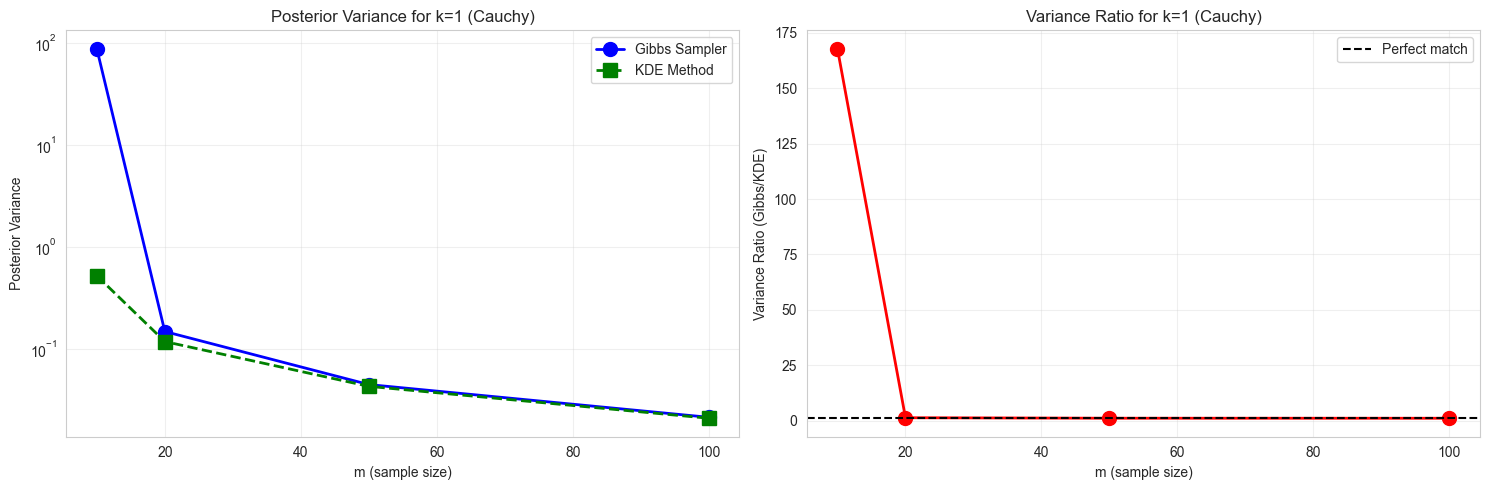

In [15]:
# Focus on k=1 (Cauchy) case - detailed analysis
print("\n" + "="*80)
print("DETAILED ANALYSIS: k=1 (Cauchy) Case")
print("="*80)

cauchy_results = df_results[df_results['k'] == 1.0].copy()
print(cauchy_results[['m', 'gibbs_variance', 'kde_variance', 'variance_ratio', 'variance_diff']].to_string(index=False))

# Plot for k=1 across different m
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

mask = df_results['k'] == 1.0
axes[0].plot(df_results[mask]['m'], df_results[mask]['gibbs_variance'], 
             'o-', label='Gibbs Sampler', linewidth=2, markersize=10, color='blue')
axes[0].plot(df_results[mask]['m'], df_results[mask]['kde_variance'], 
             's--', label='KDE Method', linewidth=2, markersize=10, color='green')
axes[0].set_xlabel('m (sample size)')
axes[0].set_ylabel('Posterior Variance')
axes[0].set_title('Posterior Variance for k=1 (Cauchy)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

axes[1].plot(df_results[mask]['m'], df_results[mask]['variance_ratio'], 
             'o-', linewidth=2, markersize=10, color='red')
axes[1].axhline(1.0, color='black', linestyle='--', label='Perfect match')
axes[1].set_xlabel('m (sample size)')
axes[1].set_ylabel('Variance Ratio (Gibbs/KDE)')
axes[1].set_title('Variance Ratio for k=1 (Cauchy)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
